# Import

In [1]:
import pandas as pd
import gtfs_kit as gk
import helper #homemade function file helper.py
import warnings
import numpy as np
import json

import seaborn as sns
import os
from datetime import datetime
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score 
from math import sqrt
from sklearn.metrics import classification_report
import matplotlib
import matplotlib.pyplot as plt
import joblib

warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# Load 


In [2]:
main_dataset = pd.read_csv("../processed_files/xmas.csv", index_col=[0])

In [3]:
classificator =  joblib.load("./models/smote/RandomForestClassifier.joblib")
regressor = joblib.load("./models/regressions/RandomForestRegressor.joblib")

In [4]:
X = main_dataset.drop(['isArrivalDelay','arrival_delay'], axis=1)
trip_ids = set(main_dataset.trip_id)
main_dataset = main_dataset.assign(classification_prevision_on_row=0)
main_dataset = main_dataset.assign(regression_prevision_on_row=0)
main_dataset = main_dataset.assign(classification_prevision_on_train=0)
main_dataset = main_dataset.assign(regression_prevision_on_train=0)

In [5]:
main_dataset

,trip_id,arrival_time,departure_time,line_index,shape_dist_traveled,time_diff,speed,dist_diff,code,direction_id,...,wind_dir_10m_line,wind_dir_100m_line,wind_gusts_line,soil_temperature_line,isArrivalDelay,isDepartureDelay,classification_prevision_on_row,regression_prevision_on_row,classification_prevision_on_train,regression_prevision_on_train
0,6,162800,162200,1,5.23393,0.10,52.0,5.23,19212,1,...,76.0,102.0,22.0,8.0,0.0,1.0,0,0,0,0
1,6,163200,162900,2,9.08714,0.05,77.0,3.85,19212,1,...,92.0,104.0,14.0,7.0,1.0,1.0,0,0,0,0
2,6,163900,163300,3,16.41975,0.10,73.0,7.33,19212,1,...,124.0,124.0,15.0,7.0,1.0,1.0,0,0,0,0
3,6,164400,164000,4,19.92630,0.07,53.0,3.51,19212,1,...,138.0,129.0,17.0,7.0,1.0,1.0,0,0,0,0
4,6,164900,164500,5,23.30757,0.07,51.0,3.38,19212,1,...,138.0,129.0,17.0,7.0,0.0,1.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,123,221700,220800,4,23.53195,0.15,53.0,8.02,18605,0,...,303.0,286.0,13.0,6.0,0.0,1.0,0,0,0,0
151,125,204800,204200,1,8.01853,0.10,80.0,8.02,18606,0,...,294.0,283.0,15.0,7.0,1.0,1.0,0,0,0,0
152,125,205700,204900,2,14.83468,0.13,51.0,6.82,18606,0,...,264.0,275.0,19.0,6.0,1.0,1.0,0,0,0,0
153,125,210800,205800,3,20.90887,0.17,36.0,6.07,18606,0,...,228.0,268.0,17.0,6.0,0.0,1.0,0,0,0,0


# Classification and Prediction

In [6]:
for i in trip_ids:
    df = X.loc[(X.trip_id == i)]
    df.reset_index(drop=True)
    if(not df.empty):
        for index, row in df.iterrows():
                #Classification i < max index
                value = classificator.predict([row.values])
                main_dataset.loc[(main_dataset.trip_id == i) & 
                                 (main_dataset.line_index == row['line_index']),
                        'classification_prevision_on_row'] = value
                
                df.loc[(df.trip_id == i) & (df.line_index == row['line_index']),
                        'isArrivalDelay'] = value
                
                #Regression i < max index
                temp = df.loc[index:index].copy()
                temp.drop(columns=["trip_id","line_index","code","day_date"
                                         ], inplace=True)
                
                if(value > 0 ):
                    rit_val = regressor.predict(temp.values)
                    main_dataset.loc[(main_dataset.trip_id == i) & (main_dataset.line_index == row['line_index']),
                                    'regression_prevision_on_row'] = rit_val
                    #df.loc[index+1,'ritardo_partenza'] = rit_val
                    df = df.drop(['isArrivalDelay'], axis=1)
    else:
        main_dataset = main_dataset.loc[(main_dataset.trip_id != i)]

In [7]:
del row,df,X,temp

# Result

In [8]:
result= main_dataset.copy()

In [9]:
result.drop(columns=["arrival_time","departure_time","shape_dist_traveled","time_diff",
                     "speed","dist_diff","code","direction_id","day_date",
                     "temperature_line","app_temp_line","rain_line","snow_fall_line","snow_depth_line","humidity_line",
                     "precipitation_line","wmo_code_line","wind_speed_10m_line","wind_speed_100m_line",
                     "wind_dir_10m_line","wind_dir_100m_line",
                     "wind_gusts_line","soil_temperature_line"
                                         ], inplace=True)

In [10]:
#result['regression_prevision_on_train'] = round(result.regression_prevision_on_train,0)
#result['regression_prevision_on_row'] = round(result.regression_prevision_on_row,0)

In [11]:
result["regression_prevision_on_row"] = result["regression_prevision_on_row"].astype(float)

result["isDepartureDelay"] = result["isDepartureDelay"].astype(bool)
result["isArrivalDelay"] = result["isArrivalDelay"].astype(bool)
result["classification_prevision_on_row"] = result["classification_prevision_on_row"].astype(bool)


In [12]:
result.to_csv("result.csv")

In [13]:
actual = result.isArrivalDelay.values
predicted = result.classification_prevision_on_row.values
print(classification_report(actual, predicted))                                                     

              precision    recall  f1-score   support

       False       0.73      0.79      0.76        38
        True       0.93      0.91      0.92       117

    accuracy                           0.88       155
   macro avg       0.83      0.85      0.84       155
weighted avg       0.88      0.88      0.88       155



In [14]:
n = len(result)
total_for_mae = 0
total_for_mse = []

# for loop for iteration 
for i in range(n): 
    if(result.loc[i, 'classification_prevision_on_row'] == 1): 
        value = result.loc[i,'arrival_delay'] - result.loc[i,'regression_prevision_on_row']
        total_for_mae += abs(value)
        total_for_mse.append(value)

df = result.loc[(result['classification_prevision_on_row'] == 1)]
actual = df.arrival_delay.values
predicted = df.regression_prevision_on_row.values


mae = total_for_mae/n 
mse = np.square(total_for_mse).mean()
rmse = sqrt(mse)

# display 
print("Mean absolute error : " + str(mae)) 
print("Mean squared error : " + str(mse))
print("Root mean squared error : " + str(rmse))

#del df,actual,predicted


Mean absolute error : 0.41425806451612907
Mean squared error : 0.699709649122807
Root mean squared error : 0.8364864906995253


In [15]:
actual

array([2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 2, 3, 4, 1, 2, 2,
       0, 0, 1, 2, 1, 1, 1, 2, 8, 8, 8, 9, 7, 7, 8, 9, 9, 7, 8, 8, 8, 5,
       5, 6, 6, 2, 2, 3, 1, 1, 1, 1, 1, 2, 2, 8, 6, 6, 4, 4, 4, 4, 2, 2,
       2, 1, 1, 4, 2, 3, 3, 3, 2, 1, 3, 1, 2, 3, 1, 2, 2, 1, 1, 1, 2, 2,
       1, 2, 1, 1, 0, 2, 2, 3, 1, 1, 3, 2, 2, 0, 2, 1, 2, 2, 0, 2, 2, 1,
       1, 2, 0, 2])

In [16]:
width = 12
height = 10

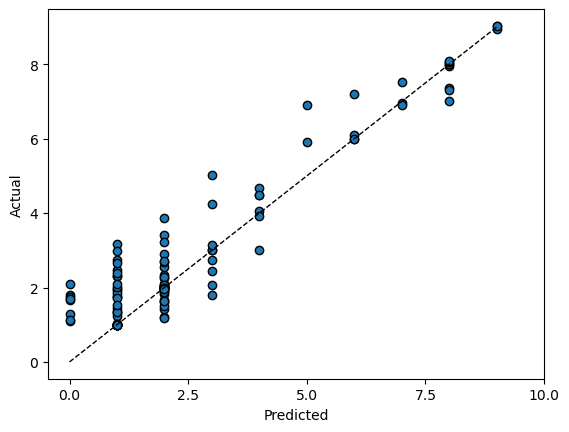

In [17]:
fig, ax = plt.subplots()
ax.scatter(actual, predicted , edgecolors=(0, 0, 0))
ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=1)
plt.xticks(np.arange(0, actual.max()+2.5, 2.5))
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
fig.savefig("../images/results/xmas_plot.png",dpi=300)
plt.show()


/var/folders/zt/4qm_9p2d267_7b0p2r1hsg840000gn/T/ipykernel_50595/1753463640.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(actual, hist=False, color="r", label="Actual Value")
/var/folders/zt/4qm_9p2d267_7b0p2r1hsg840000gn/T/ipykernel_50595/1753463640.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed297

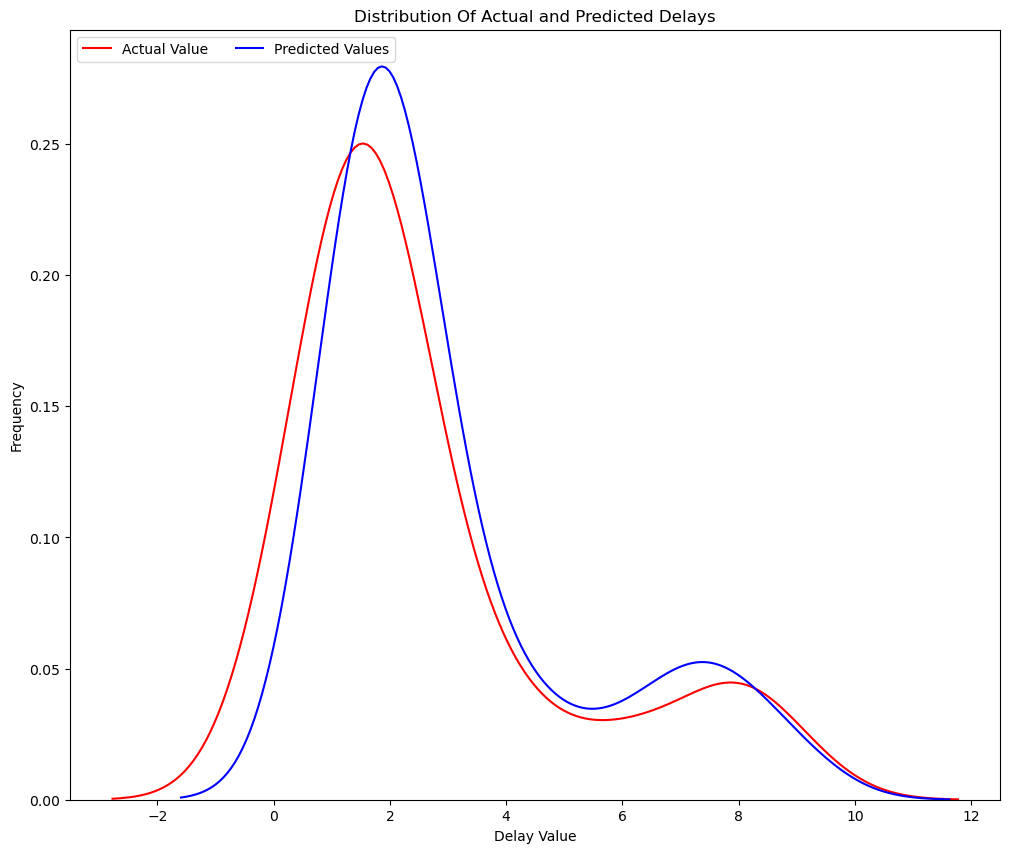

In [18]:
plt.figure(figsize=(width, height))


ax1 = sns.distplot(actual, hist=False, color="r", label="Actual Value")
sns.distplot(predicted, hist=False, color="b", label="Predicted Values" , ax=ax1)
ax1.legend(loc='upper left', ncols=2)


plt.title('Distribution Of Actual and Predicted Delays')
plt.xlabel('Delay Value')
plt.ylabel('Frequency')
plt.savefig("../images/results/xmas_distr.png")

plt.show()
plt.close()

In [22]:
error = actual - predicted
error = np.abs(error)
percentile50 = np.percentile(error, 50) 
percentile75 = np.percentile(error, 75) 
percentile90 = np.percentile(error, 90) 
percentile95 = np.percentile(error, 95) 
percentile99 = np.percentile(error, 99) 
print(percentile50)
print(percentile75)
print(percentile90)
print(percentile95)
print(percentile99)

0.3450000000000001
0.9475
1.6030000000000006
1.8209999999999997
2.0896000000000003
